# Disclaimer

This can only properly be run on a heavy duty PC

In [ ]:
training_rows_to_read = 2500000 # This needs to be 15000000

# Imports

In [1]:
from ebay_delivery_prediction_project import preprocessing, Visualisation, preprocessing_models, postprocessing
preprocessing.import_test()

from datetime import datetime, timedelta

Preprocessing successfully imported.


In [2]:
# data_object = Preprocessing.read_data(rows_to_read = None, columns = ["b2c_c2c"])
# data_object = Preprocessing.read_data(rows_to_read = None)
training_data = preprocessing.read_data(rows_to_read = training_rows_to_read)["train"]
print(training_data.columns)

Reading 1000000 rows.
Reading all columns.
Index(['b2c_c2c', 'seller_id', 'declared_handling_days',
       'acceptance_scan_timestamp', 'shipment_method_id', 'shipping_fee',
       'carrier_min_estimate', 'carrier_max_estimate', 'item_zip', 'buyer_zip',
       'category_id', 'item_price', 'quantity', 'payment_datetime',
       'delivery_date', 'weight', 'weight_units', 'package_size',
       'record_number'],
      dtype='object')


# Setting up pipeline

## Target column

The objective is to estimate the total number of calendar days (after payment) it will take to have a purchased item show up at the buyer’s address. This is equivalent to estimating the delivery date using the formula:

payment date (local time) + delivery calendar days = delivery date (local time).

Participants should provide this delivery date in their submissions.

_Now to generate target column_

### Run the basic preprocessing steps

In [3]:
training_data = preprocessing.basic_preprocessing(training_data)

Finished parse_datetime_columns
Finished create_delivery_calendar_days
Finished clean_zip_codes


In [4]:
training_data["delivery_calendar_days"].describe()

count    1000000.000000
mean           4.750261
std            3.118329
min         -117.000000
25%            3.000000
50%            4.000000
75%            5.000000
max          214.000000
Name: delivery_calendar_days, dtype: float64

In [5]:
for col in training_data.columns:
    print(f"{col} : {len(training_data[col].unique())}")

b2c_c2c : 2
seller_id : 378601
declared_handling_days : 12
acceptance_scan_timestamp : 450084
shipment_method_id : 21
shipping_fee : 3574
carrier_min_estimate : 6
carrier_max_estimate : 6
item_zip : 31216
buyer_zip : 32986
category_id : 33
item_price : 16245
quantity : 58
payment_datetime : 988627
delivery_date : 720
weight : 637
weight_units : 2
package_size : 5
record_number : 1000000
delivery_calendar_days : 129
cleaned_item_zip : 27157
cleaned_buyer_zip : 31623
distance_between_pincodes : 962601


# Implementing pipeline

## Arbitrarily choosing how to encode columns

In [14]:
different_types_of_encoding = ["one-hot", "numerical"]

cols_and_encoding = {
    "b2c_c2c"   : "one-hot",
    "seller_id"   : 6365,
    "declared_handling_days"   : "numerical",
    "acceptance_scan_timestamp"   : 9848,
    "shipment_method_id"   : "one-hot",
    "shipping_fee"   : "numerical",
    "carrier_min_estimate"   : 4, # Cheating?
    "carrier_max_estimate"   : 5, # Cheating?
    "item_zip"   : 4701, # Needs a lot of preprocessing.
    "buyer_zip"   : 6880, # Needs a lot of preprocessing.
    "category_id"   : 'one-hot', # Only has 33 unique values in 15,000,000 rows so one-hot.
    "item_price"   : "numerical",
    "quantity"   : "numerical",
    "payment_datetime"   : 9998,
    "delivery_date"   : 602,
    "weight"   : "numerical",
    "weight_units"   : 1,
    "package_size"   : "one-hot",
    "record_number"   : 10000,
    "delivery_calendar_days"   : "target",
    "cleaned_item_zip" : 30743,
    "cleaned_buyer_zip" : 34876,
    "distance_between_pincodes" : "numerical",
}

In [15]:
cols_to_convert_to_one_hot = [ele for ele in cols_and_encoding.keys() if cols_and_encoding[ele] == "one-hot"]

print("cols_to_convert_to_one_hot : ", cols_to_convert_to_one_hot)

print("training_data.shape before : ", training_data.shape)
training_data, generated_columns = preprocessing.one_hot_encode_columns(df = training_data, columns = cols_to_convert_to_one_hot)
print("training_data.shape after : ", training_data.shape)

cols_to_convert_to_one_hot :  ['b2c_c2c', 'shipment_method_id', 'category_id', 'package_size']
training_data.shape before :  (1000000, 80)


KeyError: 'b2c_c2c'

In [16]:
target_column = "delivery_calendar_days"
cols_to_use = [ele for ele in cols_and_encoding.keys() if (type(cols_and_encoding[ele]) == str) and
               (cols_and_encoding[ele] != "target") and
               (cols_and_encoding[ele] != "one-hot")]
cols_to_use = [*cols_to_use, *generated_columns]

## Running a gradient boosted decision tree model

In [17]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [18]:
# To define the input and output feature
# x = training_data.drop(['Embarked','PassengerId'],axis=1)
x = training_data[cols_to_use]
y = training_data[target_column]
# train and test split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.33,random_state=42)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((670000, 67), (330000, 67), (670000,), (330000,))

In [19]:
model = lgb.LGBMRegressor(learning_rate=0.1,max_depth=-5,random_state=42)
model.fit(x_train,y_train,eval_set=[(x_test,y_test),(x_train,y_train)],
          verbose=10,eval_metric='logloss')# This loss needs to mirror the loss that Ebay is using.

[10]	training's l2: 8.41676	valid_0's l2: 8.60024
[20]	training's l2: 8.15184	valid_0's l2: 8.42582
[30]	training's l2: 8.03675	valid_0's l2: 8.3771
[40]	training's l2: 7.97719	valid_0's l2: 8.35636
[50]	training's l2: 7.94196	valid_0's l2: 8.34511
[60]	training's l2: 7.91489	valid_0's l2: 8.33939
[70]	training's l2: 7.89361	valid_0's l2: 8.33629
[80]	training's l2: 7.87846	valid_0's l2: 8.33348
[90]	training's l2: 7.86417	valid_0's l2: 8.32983
[100]	training's l2: 7.85045	valid_0's l2: 8.32802


LGBMRegressor(max_depth=-5, random_state=42)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

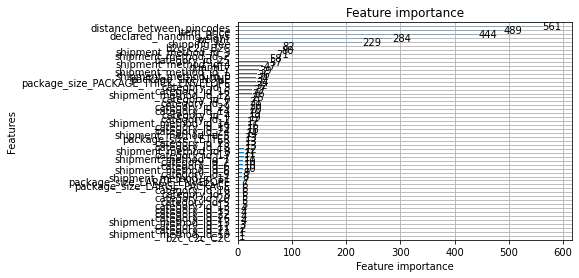

In [28]:
lgb.plot_importance(model)

In [29]:
feature_importances = {}

for importance, feature in zip(model.feature_importances_, model.feature_name_):
    feature_importances[feature] = importance

feature_importances

In [30]:
print('Training accuracy {:.4f}'.format(model.score(x_train,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(x_test,y_test)))

Training accuracy 0.1906
Testing accuracy 0.1481


In [31]:
# training_data["model_outputs"] = model.predict(training_data[cols_to_use])

In [32]:
modes_dict = {}
for col in training_data:
    modes_dict[col] = training_data[col].mode()

In [33]:
del training_data
quiz_data = preprocessing.read_data(rows_to_read = 2500000)["quiz"]

quiz_data = preprocessing.parse_datetime_columns(quiz_data)

quiz_data, generated_columns = preprocessing.one_hot_encode_columns(df = quiz_data, columns = cols_to_convert_to_one_hot)


Reading 2500000 rows.
Reading all columns.


KeyboardInterrupt: 

In [ ]:
# Filling in the blanks from non existing 

for col in model.feature_name_:
    if col not in quiz_data.columns:
        print("col : ", col)
        quiz_data[col] = modes_dict[col]

In [ ]:
quiz_data["model_outputs"] = model.predict(quiz_data[cols_to_use])

# Postprocessing

After this is all done and predicting with a decent accuracy this needs to be put back and the output needs to predict the delivery date.

The submission is a tsv table, which can be gzipped, with no headeron thw quiz dataset for now. After we win the first phase the test dataset will be given to us.

Each line should contain two values, first the record identifier from the distributed dataset, which is an integer, and second the predicted delivery date as a string in the format YYYY-MM-DD.

All records must be predicted.

In [ ]:
output_columns_name = "predicted_delivery_date"

In [ ]:
postprocessing.generate_output_column(df = quiz_data, 
                                      predicted_days_column="model_outputs",
                                     output_columns_name = output_columns_name)

In [ ]:
postprocessing.generate_submission_file(df = quiz_data, predicted_dates_column="predicted_delivery_date")

# Double checking outputs

In [ ]:
import pandas as pd

In [ ]:
submission = pd.read_csv("./results/result_2021-12-19 00:30:37.tsv", sep='\t', header = None)

In [ ]:
submission